In [1]:

import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from data import fut_list, fut_read, stock_read, pair
from util import adf_test, data_generator, significant, johansen_cointegration_test, EG, benefits_show
import warnings
warnings.filterwarnings("ignore")



# Config

In [2]:

fut = fut_list[0]
feature = 'ChangeRatio'
OUTPUT_PATH = './output'
fut
# fut_list

'CU9999.XSGE'

# DATA
* 数据基础已经全部存在data里了。只需进一步处理得到想要的时间序列。

In [3]:

fut_df = fut_read(fut)
stock_df = stock_read(fut)

### 如果想要定制特征，处理fut_df \ stock_df即可。

# ADF验证是否平稳

In [91]:
adf_list = []
for idx, df in enumerate(stock_df):
   adf_list.append(adf_test(df[feature]))
adf_list.append(adf_test(fut_df[feature]))
adf_df = pd.concat(adf_list, axis=1)   
adf_df = adf_df.T
del adf_df['Number of Observations Used']
adf_df
with open(f'{OUTPUT_PATH}/adf_test.txt', 'a') as f:
   f.write(fut + '\n')
   f.write('\n')
adf_df.to_csv(f'{OUTPUT_PATH}/adf_test.txt', mode='a')


对于changeratio而言，是平稳的

# 根据模型找出各个stock的联动显著时间段
* 由于只有VAR，故不再对模型选择进行分支。
* 由于p=0.05基本找不到显著的时间段，改成了0.10
* y是股票的y。第一个p是const的，第二个是期货前一时刻特征的p，第三个是股票前一时刻的特征的p。

## 先算一下相关性
* 这个只算了一个期货和具体股票某个特征的收益。
* 看下面收益率的corr，相关性还挺高。
* 与此同时，把数据的describe也写上了。

In [87]:
corr_list = []
data_describe = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    with open(f"{OUTPUT_PATH}/corr.txt", "a") as f:
        f.write(f"期货名{fut}")
        f.write('\n')
        f.write(f"股票名:{pair[fut][idx]}")
        f.write('\n')
        f.write(str(data.corr()) + '\n')
        f.write('\n')
        f.write('\n')
    with open(f"{OUTPUT_PATH}/describe.txt", "a") as f:
        f.write(f"期货名{fut}")
        f.write('\n')
        f.write(f"股票名:{pair[fut][idx]}")
        f.write('\n')
        f.write(str(data.describe()) + '\n')
        f.write('\n')
        f.write('\n')
# data_describe

#### 主意这个找显著，都是90%置信读就行。因为95%的找不到。

In [27]:
fut

'CU9999.XSGE'

In [4]:
feature = 'close'
sig_col = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig_col.append(significant(data))
sig_col
# 要画什么图根据这个再改一改。

[([[0, array([6.80527306e-02, 3.68049539e-02, 1.93441732e-18])],
   [1, array([9.31516594e-02, 4.76386610e-02, 3.17898540e-18])],
   [27, array([0.02226734, 0.09665104, 0.00028033])],
   [28, array([0.01048047, 0.06355264, 0.00069455])],
   [29, array([0.00893796, 0.05984495, 0.00191767])],
   [30, array([0.00526374, 0.0445393 , 0.00393313])],
   [31, array([0.00268718, 0.0400875 , 0.00749111])],
   [32, array([0.00148928, 0.03650476, 0.03884123])],
   [33, array([0.002974  , 0.04138289, 0.0251497 ])],
   [34, array([0.01230669, 0.08805706, 0.04198707])],
   [41, array([0.01039036, 0.04236885, 0.00944075])],
   [42, array([0.01123801, 0.04683293, 0.0074611 ])],
   [43, array([0.00609488, 0.02649098, 0.01388793])],
   [45, array([1.16445694e-02, 2.29788190e-02, 8.78500155e-05])],
   [46, array([2.92668824e-02, 5.60583202e-02, 4.84111241e-06])],
   [47, array([4.30460784e-02, 8.57746633e-02, 1.14984731e-06])],
   [48, array([5.44813923e-02, 9.91044721e-02, 4.54050402e-07])],
   [50, arra

上面sig为list。list 0-4表明对应的stock。

比如list[0]中，就存了期股联动显著的时间切片。list中第一个数字是时间切片编号，第二个是三个p。p的解释如上

sig_col 即为显著的index

还有更进一步的算最佳lead lag,不过都是1，所以似乎不重要了,写在下面。可以尝试下冲击

```python
lag_order = model.select_order(15)
print(f"Selected lag order: {lag_order.selected_orders['aic']}")
model_fitted = model.fit(maxlags=lag_order.selected_orders['aic'])
print(model_fitted.summary())

irf = model_fitted.irf(10) # 10期冲击响应
irf.plot(orth=True) # 正交化冲击响应图
plt.show()

```

# VAR 冲击效应

Selected lag order: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Apr, 2024
Time:                     21:01:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.5840
Nobs:                     1172.00    HQIC:                  -16.6109
Log likelihood:           6427.54    FPE:                6.01036e-08
AIC:                     -16.6272    Det(Omega_mle):     5.95940e-08
--------------------------------------------------------------------
Results for equation ChangeRatio_Future
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000353         0.000321            1.100           0.271
L1.ChangeRatio_Future        -0.085180         0.033901           -2.513          

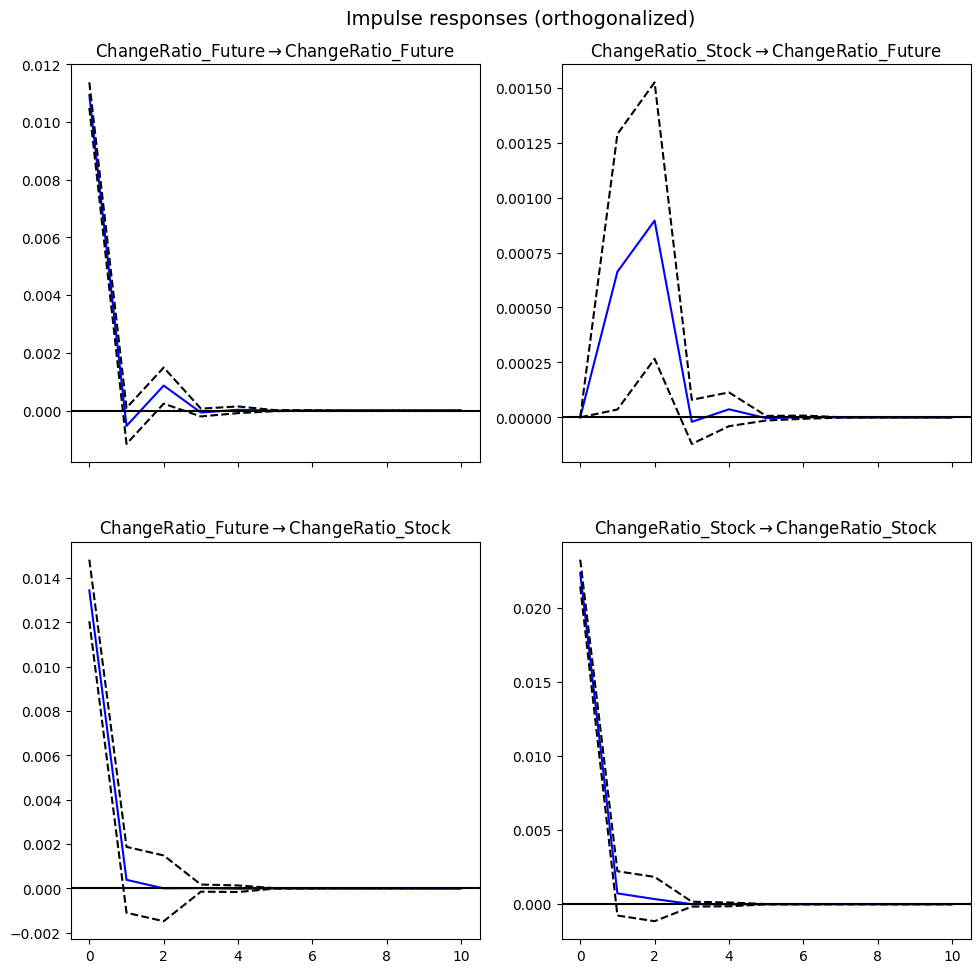

In [7]:
feature = 'ChangeRatio'
data, label = data_generator(fut_df, stock_df[0], feature)
model = VAR(data)
lag_order = model.select_order(15)
print(f"Selected lag order: {lag_order.selected_orders['aic']}")
model_fitted = model.fit(maxlags=lag_order.selected_orders['aic'])
print(model_fitted.summary())

irf = model_fitted.irf(10) # 10期冲击响应
irf.plot(orth=True) # 正交化冲击响应图
plt.show()

# 画图

In [9]:
import matplotlib.pyplot as plt

feature = 'ChangeRatio'
fig_list = []
# sign = [0, 62, 132, 0, 93] # close的
# sign = [445, 117, 241, 233, 1042] # ChangeRatio的
sign = [100, 300, 300, 100, 500]
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    fig= benefits_show(sign[idx], data, idx, fut_df, stock_df, feature)
    fig_list.append(fig)
    fig.savefig(f'figure_{idx+10}.png')
    plt.close(fig)  # 关闭图形以释放内存


1170
1174
1164
1174
1174


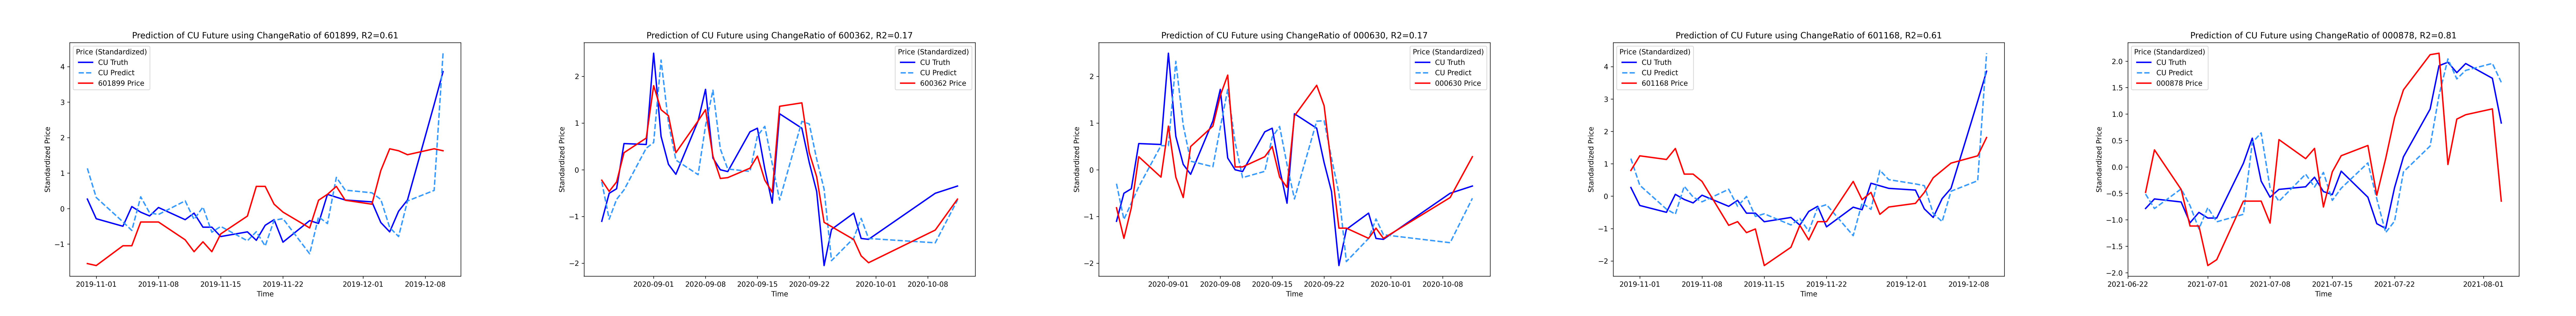

In [29]:
fig, axes = plt.subplots(1, len(fig_list), figsize=(40, 20), dpi=250)  # 根据需要调整布局和尺寸

# 重新读取图像文件并添加到子图中
for i, ax in enumerate(axes):
    image_data = plt.imread(f'figure_{i+10}.png')  # 读取保存的图像文件
    ax.imshow(image_data)
    ax.axis('off')  # 关闭坐标轴
    # ax.set_title(f'R^2:{r_list[i]}', fontsize=10)
plt.tight_layout()
plt.show()  # 显示图形

# 协整检验
* 只用检验上面的data数据（就是一列是期货数据，一列是股票数据）

!! 只看一次，所以只用了一个break

In [71]:
# print('Results of Johansen Cointegration Test:')
# print(f"Test statistic: {result.lr1}")
# print(f"Critical values: {result.cvt}")
# print(f"Eigenstatistics: {result.lr2}")
# print(f"Eigenvalues: {result.eig}")
Test_statistic = []
Critical_values = []
Eigenstatistic = []
Eigenvalues = []
for idx, df in enumerate(stock_df):
    data = data_generator(fut_df, df, feature)
    test_result = johansen_cointegration_test(data[0])
    Test_statistic.append(test_result.lr1)
    Critical_values.append(test_result.cvt)
    Eigenstatistic.append(test_result.lr2)
    Eigenvalues.append(test_result.eig)

# 可以很方便的改成df

In [77]:
Critical_values
# pd.DataFrame(Critical_values)

[array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]])]

# VAR回归系数

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from data import fut_list, fut_read, stock_read, pair
from util import adf_test, data_generator, significant, johansen_cointegration_test, EG, benefits_show
feature = 'ChangeRatio'
sign = [2, 2, 2, 2, 2] # 对应return，全局系数
# sign = [3, 4, 3 ,3 ,1]
# sign = [0, 3, 161, 10, 6]  #这个对应close
# sign = [445, 117, 241, 233, 1042] # 这个对应return
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    # significant_idx= sign[idx]
    # window_size = 30
    # window_start = significant_idx
    # window_end = significant_idx + window_size
    # window_data = data.iloc[window_start:window_end]
    model = VAR(data)
    results = model.fit(sign[i])
    results.params
    with open(f'{OUTPUT_PATH}/params_{feature}.txt', 'a') as file:
        file.write(f"# feature: {feature}\n")
        file.write(f"# 期货{fut}\n")
        file.write(f"# 股票{pair[fut][idx]}\n")
        file.write(f"significant_idx:{significant_idx}\n")
        file.write("\n")
        results.params.round(2).to_csv(file, sep='\t')
        file.write("\n")
    

# E-G协整检验

* 对回归残差的检验

* result是股票对期货回归得到的模型的参数。比如t值 p值 r^2等

In [67]:
feature = 'close'
result_list = []
output_list = []
for df in stock_df:
    data, label = data_generator(fut_df, df, feature)
    result_df, output = EG(data)
    result_df = result_df['r_squared']
    result_list.append(result_df)
    output_list.append(output)
output_df = pd.concat(output_list, axis=1)
output_df = output_df.round(2)
res_df = pd.concat(result_list, axis=1)
res_df = res_df.round(2)
res_df.index = ['r^2', 'r^2']
res_df.columns = [pair[fut][i] for i in range(len(pair[fut]))]
output_df.columns = [pair[fut][i] for i in range(len(pair[fut]))]
df = pd.concat([output_df, res_df])
df.to_csv(f'{OUTPUT_PATH}/EG_output_{feature}.csv', sep='\t')

# VECM

### 下面这个是VAR的

下面表明最好的lag一般是1

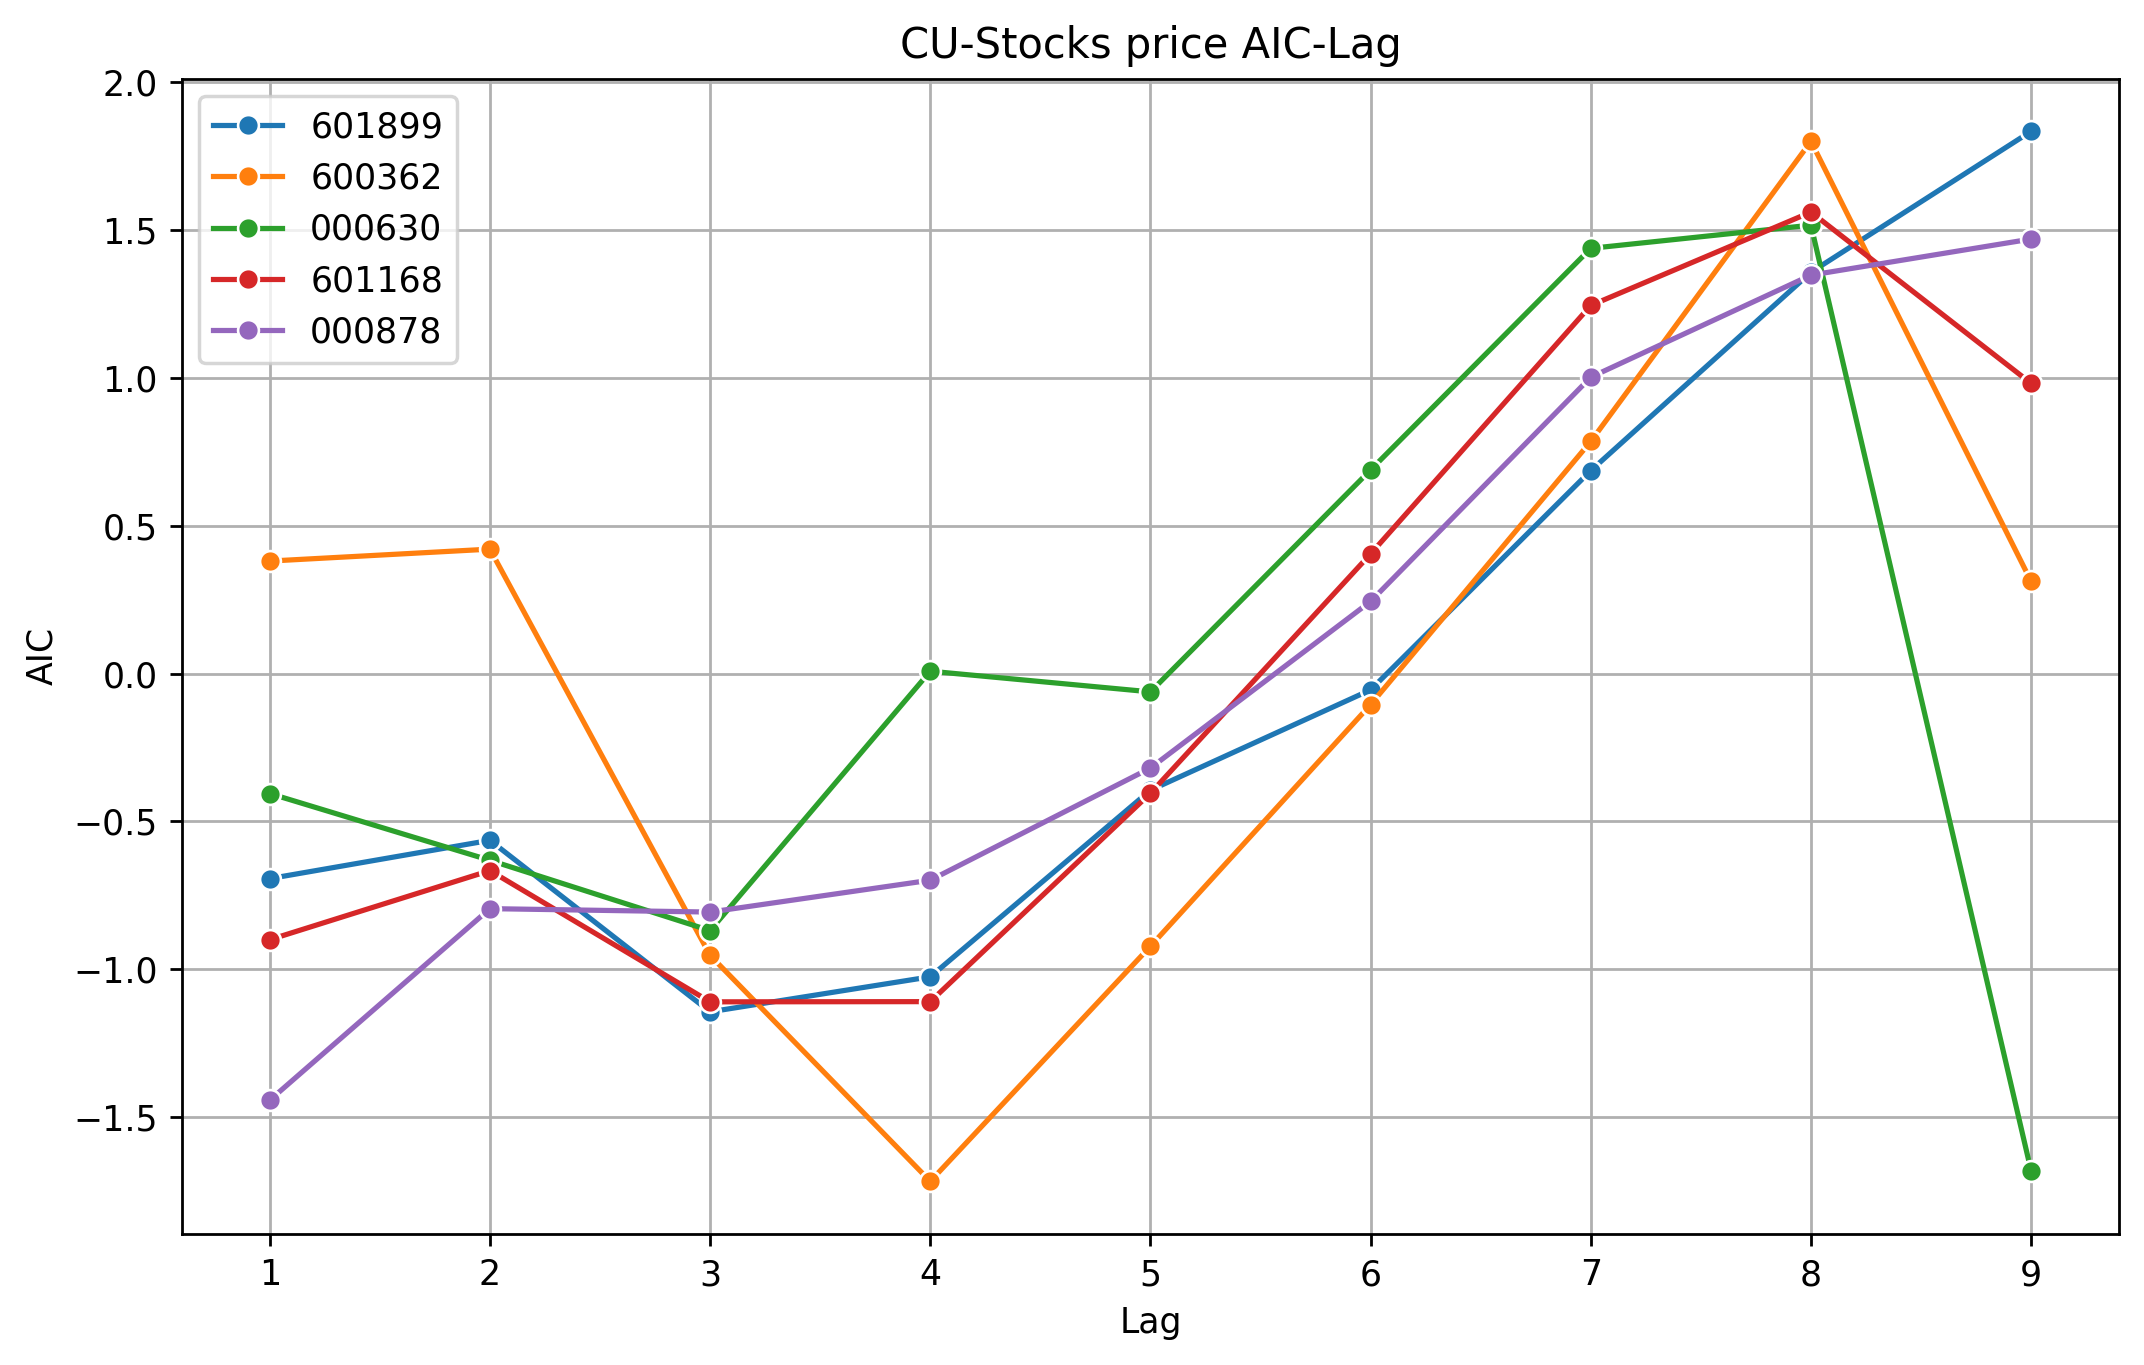

In [35]:
feature = 'close'
plt.figure(figsize=(10, 6), dpi=250)
ans = []
for idx, df in enumerate(stock_df):
    aic_values = []
    data, label = data_generator(fut_df, df, feature)

    for lag in range(1, 10):
        model = VAR(data)
        results = model.fit(lag)
        aic = results.aic
        aic_values.append(aic)
    df = pd.DataFrame({'Lag': np.linspace(1,9,9), 'AIC': aic_values})

    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df['AIC'] = scaler.fit_transform(df[['AIC']])
    ans.append(df['AIC'])
    sns.lineplot(data=df, x='Lag', y='AIC', marker='o', label= f'{pair[fut][idx]}')
    plt.title(f'{fut[:2]}-Stocks price AIC-Lag')
    plt.xlabel('Lag')
    plt.ylabel('AIC')
    plt.grid(True)
ans = pd.concat(ans, axis=1)
ans = ans.round(2)
ans.columns = [pair[fut][i] for i in range(len(stock_df))]
ans.to_csv(f"{OUTPUT_PATH}/VAR_AIC_{feature}.csv")
plt.legend() 
plt.savefig(f'{OUTPUT_PATH}/{fut[:2]}-Stocks price AIC-Lag.png')

## 求AIC

In [13]:
ans = pd.DataFrame()
feature = 'close'
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    aic_values = []
    for lag in range(1, 10):
        model = VAR(data)
        results = model.fit(lag)
        aic_values.append(results.aic)
    tmp = pd.DataFrame( {f'AIC_stock{idx+1}': aic_values}).T
    ans = pd.concat([ans, tmp], axis=0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for idx in ans.index:
    ans.loc[idx] = scaler.fit_transform(ans.loc[idx].values.reshape(-1, 1)).reshape(-1)
ans = ans.round(2)
ans.index = [pair[fut][idx] for idx in range(len(stock_df))]
ans.to_csv(f'{OUTPUT_PATH}/VAR_AIC_close.csv')
# scaled.index = [pair[fut][idx] for idx in range(len(stock_df))]
# scaled.to_csv(f'{OUTPUT_PATH}/VAR_AIC_{feature}.csv')

## 求统计量

In [10]:
feature = 'close'
data, label = data_generator(fut_df, stock_df[4], feature)
model = VAR(data)
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Apr, 2024
Time:                     12:26:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.3510
Nobs:                     1173.00    HQIC:                   10.3349
Log likelihood:          -9378.50    FPE:                    30488.1
AIC:                      10.3251    Det(Omega_mle):         30332.8
--------------------------------------------------------------------
Results for equation close_Future
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 177.397792       162.379847            1.092           0.275
L1.close_Future         0.997345         0.002047          487.136           0.000
L1.close_Stock          0.696846        12.00

## 求系数

In [21]:
beta_list = []
alpha_list = []
# sign = [3,4, 3, 3, 1]
sign = [2,2, 2,2,2]
feature = 'ChangeRatio'
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    model = VAR(data)
    results = model.fit(sign[idx])
    beta_list.append(results.params[f'{feature}_Stock'].round(5))
    alpha_list.append(results.params[f'{feature}_Future'].round(5))
beta_df = pd.concat(beta_list, axis=1)
alpha_df = pd.concat(alpha_list, axis=1)
beta_df.columns = [pair[fut][idx] for idx in range(len(stock_df))]
alpha_df.columns = [pair[fut][idx] for idx in range(len(stock_df))]
alpha_df.to_csv(f'{OUTPUT_PATH}/VARs_alpha_Regrad_stock_as_y(result)——{feature}.csv')
beta_df.to_csv(f'{OUTPUT_PATH}/VARs_beta_Regrad_stock_as_y(result)——{feature}.csv')

In [19]:
alpha_df

,601899,600362,000630,601168,000878
const,0.00033,0.00042,0.00041,0.00038,0.00047
L1.ChangeRatio_Future,-0.08975,-0.08124,-0.05750,-0.08098,-0.05591
L1.ChangeRatio_Stock,0.03056,0.02389,0.01088,0.02646,0.00678
L2.ChangeRatio_Future,0.02146,0.01101,0.04734,0.05241,NaN
L2.ChangeRatio_Stock,0.04142,0.04651,0.02594,0.01929,NaN
L3.ChangeRatio_Future,-0.00598,-0.01414,0.01366,0.00645,NaN
L3.ChangeRatio_Stock,0.01494,0.01816,-0.00318,0.00749,NaN
L4.ChangeRatio_Future,NaN,0.02173,NaN,NaN,NaN
L4.ChangeRatio_Stock,NaN,-0.00097,NaN,NaN,NaN


### 下面这个是VECM

In [73]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
vecm_list = []
for df in stock_df:
    data, label = data_generator(fut_df, df, feature)
    lag_order = select_order(data=data, maxlags=10, deterministic="ci").selected_orders['aic']
    print(f"Selected lag order by AIC: {lag_order}")
    vecm = VECM(endog=data, k_ar_diff=lag_order, coint_rank=1, deterministic="ci")
    vecm_fitted = vecm.fit()
    vecm_list.append(vecm_fitted)


Selected lag order by AIC: 3
Selected lag order by AIC: 3
Selected lag order by AIC: 8
Selected lag order by AIC: 3
Selected lag order by AIC: 0


可能还需要看的就是VECM表中对应的信息是啥意思了。

In [75]:
vecm_list[0].summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.close_Future,-0.0685,0.035,-1.981,0.048,-0.136,-0.001
L1.close_Stock,156.5847,95.753,1.635,0.102,-31.088,344.258
L2.close_Future,0.0192,0.034,0.559,0.576,-0.048,0.087
L2.close_Stock,245.5535,96.090,2.555,0.011,57.220,433.887
L3.close_Future,-0.0137,0.034,-0.398,0.690,-0.081,0.054
L3.close_Stock,48.5442,96.342,0.504,0.614,-140.282,237.371
,coef,std err,z,P>|z|,[0.025,0.975]
L1.close_Future,1.331e-06,1.26e-05,0.106,0.916,-2.33e-05,2.6e-05
L1.close_Stock,0.0515,0.035,1.481,0.139,-0.017,0.120
L2.close_Future,-6.448e-06,1.25e-05,-0.516,0.606,-3.1e-05,1.81e-05


！！！牛魔这个每个lag对应的AIC实在找不到方法求。VECM没有提供AIC的功能，select_order只返回一个最好的lag的AIC。想画图画布不了。放弃了。

# 试着算VCM的胜率

* sig_list跟之前的sig_col是一个意思。表示显著的时间。
* acc_list则是每个时间切片的胜率。我们可以根据sig_list中显著时间对应的index直接在acc_list中找。

In [7]:
sig_list = []
acc_list = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig, acc = significant(data, label)
    sig_list.append(sig)
    acc_list.append(acc)


下面举个例子。可以看到胜率是0.73333

In [19]:
# 举个例子 改sig_list第二个索引
idx = sig_list[0][5][0]
win = acc_list[0][idx]
win

0.7333333333333333

# Granger

In [23]:
def granger(data):
    result = sm.tsa.stattools.grangercausalitytests(data, maxlag=2, verbose=False)
    p_value = result[2][0]['params_ftest'][0:2]
    # print(result)
    return p_value

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
feature = 'close'
p_value_list = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    p_value = granger(data)
    p_value_list.append(p_value)
    # with open(f'./{OUTPUT_PATH}/granger_{feature}.txt', 'a') as file:
    #     file.write(f"Granger causality test for {fut}:" + "\n")
    #     file.write(f"Granger causality test for {pair[fut][idx]}:" + "\n")
    #     file.write(f"t_value: {p_value[0].round(2)}" + "\n")
    #     file.write(f"p_value: {p_value[1].round(2)}" + "\n")
    #     file.write("\n")
    #     if p_value[1] < 0.05:
    #         file.write(f"Granger 因果检验：{fut}对 {pair[fut][idx]}有因果关系")
    #     else:
    #         file.write(f"Granger 因果检验：{fut} 对 {pair[fut][idx]} 无因果关系")
            
    #     file.write("\n")
    #     file.write("\n")
    #     file.write("\n")
    #     file.write("\n")
df = pd.DataFrame(p_value_list, columns=['t_value', 'p_value'])
df.index = [pair[fut][idx] for idx in range(len(stock_df))]
df.to_csv(f'{OUTPUT_PATH}/granger_{feature}_take_feature_as_y.csv', sep='\t')

,t_value,p_value
601899,7.919334,0.004973
600362,0.919145,0.337898
000630,1.622473,0.203000
601168,5.994474,0.014497
000878,0.003368,0.953730
